In [1]:
#| code-fold: true
#| warning: false
#| error: false
%load_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore")

import os

os.chdir("/project/persistent-exclusion-process/")

import gc

import numpy as np
import h5py
import glob
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

from src.training_utils import (
    extract_floats,
    data_load,
    split_dataset,
    predict_multi_by_name,
    predict_and_plot,
    plot_violin_and_statistics
)
from src.models import make_net
from src.plot_utils import get_plot_configs

plot_configs = get_plot_configs()
plot_configs["axes.facecolor"] = [0.96, 0.96, 0.96, 1]
plot_configs["figure.facecolor"] = [0.98, 0.98, 0.98, 1]
plt.rcParams.update(plot_configs)

np.set_printoptions(precision=3, suppress=True)
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
print(gpu_devices)

2024-03-14 21:19:05.925335: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 21:19:06.775481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
#| code-fold: true
tumbles = np.logspace(-6, -1, 10, base=2) # here are all the alphas available

x,y,shape = data_load(alphas=tumbles, densities=[0.25], orientation=False, scrambled=True)
x_train, y_train, x_val, y_val = split_dataset(x,y,last=int(len(x)*0.2))
del x
del y
gc.collect()

Number of unique alpha:  10
Shape of x:  (30000, 128, 128, 1)
Shape of y:  (30000,)
Size of training data:  24000
Size of validation data:  6000


0

# No-orientation 1 (ice1822)

In [3]:
#| code-fold: true
#| warning: false
#| error: false

tf.keras.utils.set_random_seed(1822)

model = make_net(shape)
# Slightly slower adam and SGD
adam = keras.optimizers.Adam(learning_rate=0.0002)
sgd = keras.optimizers.SGD(learning_rate=0.008)
model.compile(loss='mae', optimizer=sgd, metrics=['mae'])

2024-03-08 19:01:11.210802: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4776 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:07:00.0, compute capability: 7.5


In [4]:
#| code-fold: true
#| warning: false
#| error: false

epochs=45
batch_size=64
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose=2,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)
print("Evaluate on test data:")
results = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=0)
print("Test loss:", results)

2024-03-08 19:01:13.896469: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.
2024-03-08 19:01:14.550030: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.


Epoch 1/45


2024-03-08 19:01:15.331800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2024-03-08 19:01:15.716141: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7b4da4709b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-08 19:01:15.716167: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-03-08 19:01:15.883791: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 - 5s - loss: 0.0577 - mae: 0.0577 - val_loss: 0.2258 - val_mae: 0.2258 - 5s/epoch - 14ms/step
Epoch 2/45
375/375 - 3s - loss: 0.0390 - mae: 0.0390 - val_loss: 0.0437 - val_mae: 0.0437 - 3s/epoch - 7ms/step
Epoch 3/45
375/375 - 3s - loss: 0.0343 - mae: 0.0343 - val_loss: 0.0269 - val_mae: 0.0269 - 3s/epoch - 7ms/step
Epoch 4/45
375/375 - 3s - loss: 0.0323 - mae: 0.0323 - val_loss: 0.0311 - val_mae: 0.0311 - 3s/epoch - 7ms/step
Epoch 5/45
375/375 - 3s - loss: 0.0305 - mae: 0.0305 - val_loss: 0.0213 - val_mae: 0.0213 - 3s/epoch - 7ms/step
Epoch 6/45
375/375 - 3s - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0233 - val_mae: 0.0233 - 3s/epoch - 7ms/step
Epoch 7/45
375/375 - 3s - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0198 - val_mae: 0.0198 - 3s/epoch - 7ms/step
Epoch 8/45
375/375 - 3s - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0261 - val_mae: 0.0261 - 3s/epoch - 7ms/step
Epoch 9/45
375/375 - 3s - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0194 - val_mae: 0.0194 - 3s/epoch - 7ms/step
Ep

Text(0.5, 1.0, 'Training and Validation MAE')

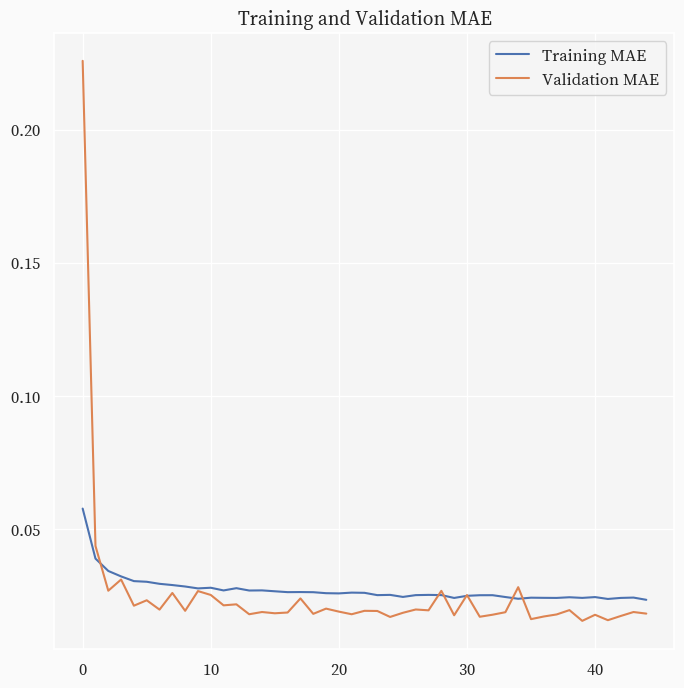

In [19]:
#| code-fold: true
#| warning: false
#| error: false

acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training MAE')
plt.plot(epochs_range, val_acc, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

188/188 [==============================] - 0s 2ms/step
Overlap ratio: 0.9
(Min, Max, Avg) STD: 1.8626451e-09 0.037014466 0.015691686
Pearson's correlation coeff:  0.9855920403338827


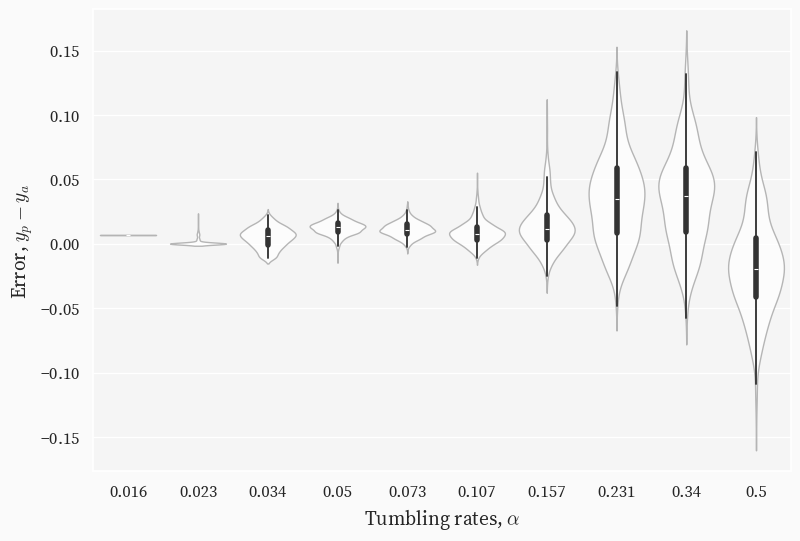

In [10]:
#| code-fold: true
#| warning: false
#| error: false

predict_and_plot(model, x_val, y_val)

In [7]:
#| code-fold: true
#| warning: false
#| error: false
# Save the model here

name = "ice1822"
model.save(f"models/{name}.keras")
np.save(f"models/{name}.npy",history.history)

In [8]:
#| code-fold: true
#| warning: false
#| error: false

import gc

del model
del history

print("Collected: ", gc.collect())

Collected:  6431


# No-orientation 2 (house9539)

In [9]:
#| code-fold: true
#| warning: false
#| error: false

tf.keras.utils.set_random_seed(9539)

model = make_net(shape)
# Slightly slower adam and SGD
adam = keras.optimizers.Adam(learning_rate=0.0002)
sgd = keras.optimizers.SGD(learning_rate=0.008)
model.compile(loss='mae', optimizer=sgd, metrics=['mae'])

In [10]:
#| code-fold: true
#| warning: false
#| error: false

epochs=45
batch_size=64
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose=2,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)
print("Evaluate on test data:")
results = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=0)
print("Test loss:", results)

2024-03-08 19:04:01.830810: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.
2024-03-08 19:04:02.396163: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.


Epoch 1/45
375/375 - 4s - loss: 0.0616 - mae: 0.0616 - val_loss: 0.2441 - val_mae: 0.2441 - 4s/epoch - 10ms/step
Epoch 2/45
375/375 - 3s - loss: 0.0415 - mae: 0.0415 - val_loss: 0.0296 - val_mae: 0.0296 - 3s/epoch - 7ms/step
Epoch 3/45
375/375 - 3s - loss: 0.0368 - mae: 0.0368 - val_loss: 0.0283 - val_mae: 0.0283 - 3s/epoch - 8ms/step
Epoch 4/45
375/375 - 3s - loss: 0.0352 - mae: 0.0352 - val_loss: 0.0304 - val_mae: 0.0304 - 3s/epoch - 7ms/step
Epoch 5/45
375/375 - 3s - loss: 0.0337 - mae: 0.0337 - val_loss: 0.0232 - val_mae: 0.0232 - 3s/epoch - 8ms/step
Epoch 6/45
375/375 - 3s - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0269 - val_mae: 0.0269 - 3s/epoch - 8ms/step
Epoch 7/45
375/375 - 3s - loss: 0.0317 - mae: 0.0317 - val_loss: 0.0300 - val_mae: 0.0300 - 3s/epoch - 8ms/step
Epoch 8/45
375/375 - 3s - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0244 - val_mae: 0.0244 - 3s/epoch - 8ms/step
Epoch 9/45
375/375 - 3s - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0341 - val_mae: 0.0341 - 3s/epoch - 

Text(0.5, 1.0, 'Training and Validation MAE')

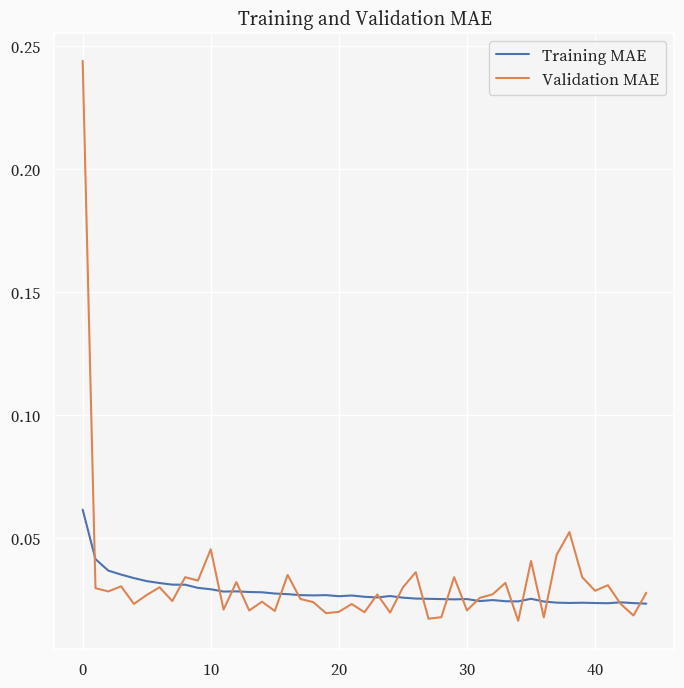

In [11]:
#| code-fold: true
#| warning: false
#| error: false

acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training MAE')
plt.plot(epochs_range, val_acc, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

188/188 [==============================] - 0s 2ms/step
Overlap ratio: 0.9
(Min, Max, Avg) STD: 0.0034993119 0.047663327 0.017375419
Pearson's correlation coeff:  0.9794216911983602


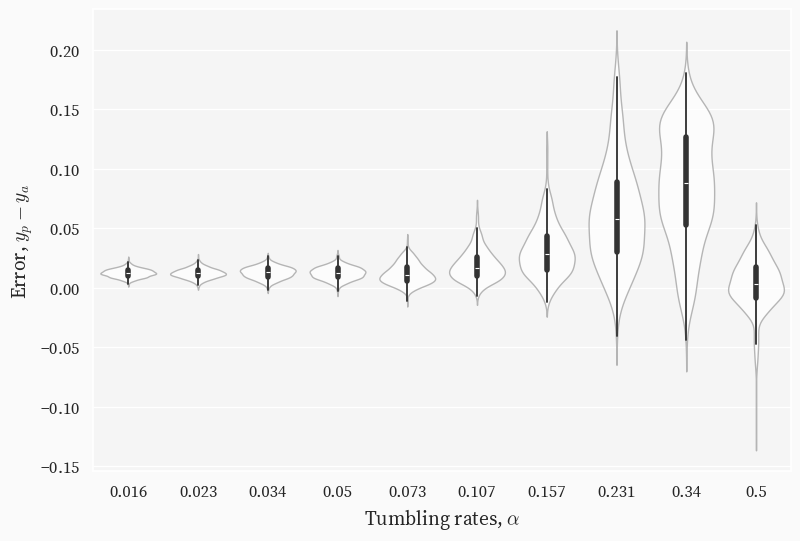

In [9]:
#| code-fold: true
#| warning: false
#| error: false

predict_and_plot(model, x_val, y_val)

In [13]:
#| code-fold: true
#| warning: false
#| error: false
# Save the model here

name = "house9539"
model.save(f"models/{name}.keras")
np.save(f"models/{name}.npy",history.history)

In [14]:
#| code-fold: true
#| warning: false
#| error: false

import gc

del model
del history

print("Collected: ", gc.collect())

Collected:  12758


# No-orientation 3 (cake2409)

In [15]:
#| code-fold: true
#| warning: false
#| error: false

tf.keras.utils.set_random_seed(2409)

model = make_net(shape)
# Slightly slower adam and SGD
adam = keras.optimizers.Adam(learning_rate=0.0002)
sgd = keras.optimizers.SGD(learning_rate=0.008)
model.compile(loss='mae', optimizer=sgd, metrics=['mae'])

In [16]:
#| code-fold: true
#| warning: false
#| error: false

epochs=45
batch_size=64
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose=2,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)
print("Evaluate on test data:")
results = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=0)
print("Test loss:", results)

2024-03-08 19:06:45.124917: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.


Epoch 1/45
375/375 - 4s - loss: 0.0479 - mae: 0.0479 - val_loss: 0.0917 - val_mae: 0.0917 - 4s/epoch - 10ms/step
Epoch 2/45
375/375 - 3s - loss: 0.0389 - mae: 0.0389 - val_loss: 0.0329 - val_mae: 0.0329 - 3s/epoch - 7ms/step
Epoch 3/45
375/375 - 3s - loss: 0.0373 - mae: 0.0373 - val_loss: 0.0249 - val_mae: 0.0249 - 3s/epoch - 7ms/step
Epoch 4/45
375/375 - 3s - loss: 0.0365 - mae: 0.0365 - val_loss: 0.0264 - val_mae: 0.0264 - 3s/epoch - 8ms/step
Epoch 5/45
375/375 - 3s - loss: 0.0344 - mae: 0.0344 - val_loss: 0.0233 - val_mae: 0.0233 - 3s/epoch - 8ms/step
Epoch 6/45
375/375 - 3s - loss: 0.0341 - mae: 0.0341 - val_loss: 0.0245 - val_mae: 0.0245 - 3s/epoch - 8ms/step
Epoch 7/45
375/375 - 3s - loss: 0.0337 - mae: 0.0337 - val_loss: 0.0349 - val_mae: 0.0349 - 3s/epoch - 8ms/step
Epoch 8/45
375/375 - 3s - loss: 0.0329 - mae: 0.0329 - val_loss: 0.0321 - val_mae: 0.0321 - 3s/epoch - 8ms/step
Epoch 9/45
375/375 - 3s - loss: 0.0330 - mae: 0.0330 - val_loss: 0.0218 - val_mae: 0.0218 - 3s/epoch - 

Text(0.5, 1.0, 'Training and Validation MAE')

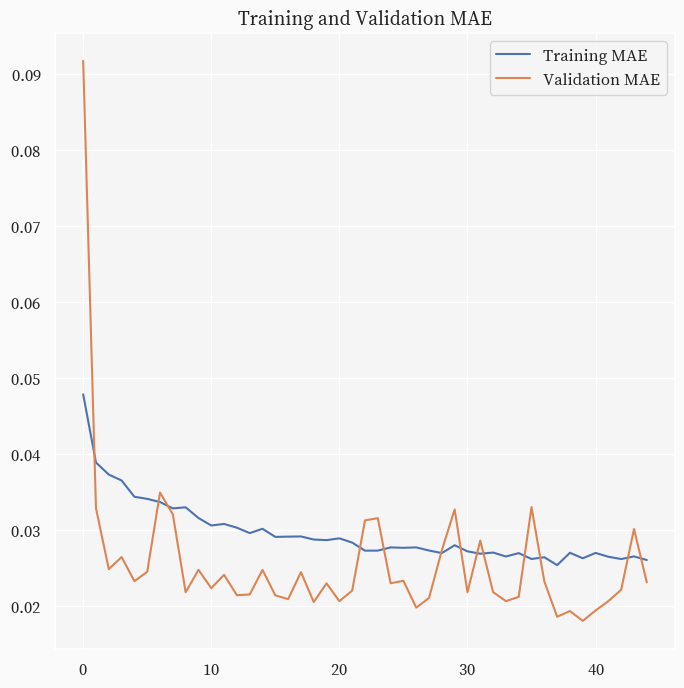

In [21]:
#| code-fold: true
#| warning: false
#| error: false

acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training MAE')
plt.plot(epochs_range, val_acc, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

188/188 [==============================] - 0s 2ms/step
Overlap ratio: 0.7
(Min, Max, Avg) STD: 0.00018223333 0.03827172 0.015196959
Pearson's correlation coeff:  0.981428819094735


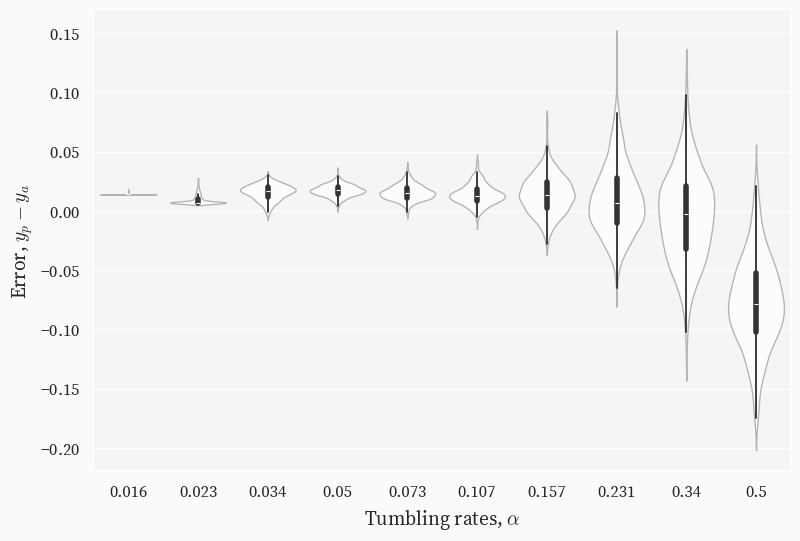

In [8]:
#| code-fold: true
#| warning: false
#| error: false

predict_and_plot(model, x_val, y_val)

In [19]:
#| code-fold: true
#| warning: false
#| error: false
# Save the model here

name = "cake2409"
model.save(f"models/{name}.keras")
np.save(f"models/{name}.npy",history.history)

In [20]:
#| code-fold: true
#| warning: false
#| error: false

import gc

del model
del history

print("Collected: ", gc.collect())

Collected:  15410


# No-orientation 4 (carrot8290)

In [9]:
#| code-fold: true
#| warning: false
#| error: false

tf.keras.utils.set_random_seed(8290)

model = make_net(shape)
# Slightly slower adam and SGD
adam = keras.optimizers.Adam(learning_rate=0.0002)
sgd = keras.optimizers.SGD(learning_rate=0.008)
model.compile(loss='mae', optimizer=sgd, metrics=['mae'])

In [10]:
#| code-fold: true
#| warning: false
#| error: false

epochs=45
batch_size=64
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose=2,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)
print("Evaluate on test data:")
results = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=0)
print("Test loss:", results)

2024-03-14 21:23:56.285668: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.
2024-03-14 21:23:56.876274: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.


Epoch 1/45
375/375 - 4s - loss: 0.0427 - mae: 0.0427 - val_loss: 0.3267 - val_mae: 0.3267 - 4s/epoch - 10ms/step
Epoch 2/45
375/375 - 3s - loss: 0.0342 - mae: 0.0342 - val_loss: 0.0252 - val_mae: 0.0252 - 3s/epoch - 8ms/step
Epoch 3/45
375/375 - 3s - loss: 0.0320 - mae: 0.0320 - val_loss: 0.0243 - val_mae: 0.0243 - 3s/epoch - 8ms/step
Epoch 4/45
375/375 - 3s - loss: 0.0306 - mae: 0.0306 - val_loss: 0.0263 - val_mae: 0.0263 - 3s/epoch - 8ms/step
Epoch 5/45
375/375 - 3s - loss: 0.0306 - mae: 0.0306 - val_loss: 0.0230 - val_mae: 0.0230 - 3s/epoch - 8ms/step
Epoch 6/45
375/375 - 3s - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0217 - val_mae: 0.0217 - 3s/epoch - 8ms/step
Epoch 7/45
375/375 - 3s - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0241 - val_mae: 0.0241 - 3s/epoch - 8ms/step
Epoch 8/45
375/375 - 3s - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0212 - val_mae: 0.0212 - 3s/epoch - 8ms/step
Epoch 9/45
375/375 - 3s - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0206 - val_mae: 0.0206 - 3s/epoch - 

Text(0.5, 1.0, 'Training and Validation MAE')

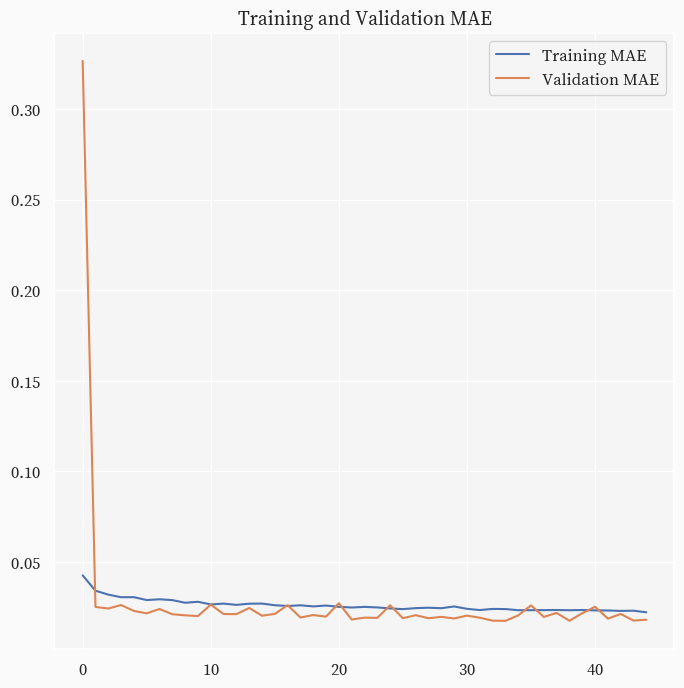

In [16]:
#| code-fold: true
#| warning: false
#| error: false

acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training MAE')
plt.plot(epochs_range, val_acc, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

188/188 [==============================] - 0s 2ms/step
Overlap ratio: 0.9
(Min, Max, Avg) STD: 1.8626451e-09 0.03835773 0.014301469
Pearson's correlation coeff:  0.985338480285781


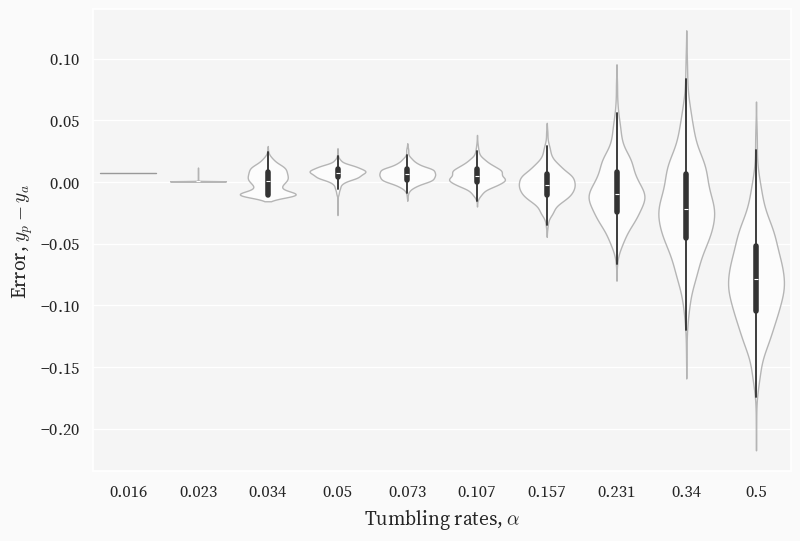

In [14]:
#| code-fold: true
#| warning: false
#| error: false

predict_and_plot(model, x_val, y_val)

In [11]:
#| code-fold: true
#| warning: false
#| error: false
# Save the model here

name = "carrot8290"
model.save(f"models/{name}.keras")
np.save(f"models/{name}.npy",history.history)

In [12]:
#| code-fold: true
#| warning: false
#| error: false

import gc

del model
del history

print("Collected: ", gc.collect())

Collected:  10458


# No-orientation 5 (virus9177)

In [3]:
#| code-fold: true
#| warning: false
#| error: false

tf.keras.utils.set_random_seed(9177)

model = make_net(shape)
# Slightly slower adam and SGD
adam = keras.optimizers.Adam(learning_rate=0.0002)
sgd = keras.optimizers.SGD(learning_rate=0.008)
model.compile(loss='mae', optimizer=sgd, metrics=['mae'])

2024-03-14 21:19:26.729636: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4299 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:07:00.0, compute capability: 7.5


In [4]:
#| code-fold: true
#| warning: false
#| error: false

epochs=45
batch_size=64
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose=2,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)
print("Evaluate on test data:")
results = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=0)
print("Test loss:", results)

2024-03-14 21:19:27.928624: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.
2024-03-14 21:19:29.592042: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.


Epoch 1/45


2024-03-14 21:19:30.607217: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2024-03-14 21:19:31.015712: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x78a42470aa40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-14 21:19:31.015746: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-03-14 21:19:31.278613: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 - 6s - loss: 0.0506 - mae: 0.0506 - val_loss: 0.1977 - val_mae: 0.1977 - 6s/epoch - 15ms/step
Epoch 2/45
375/375 - 3s - loss: 0.0383 - mae: 0.0383 - val_loss: 0.0282 - val_mae: 0.0282 - 3s/epoch - 8ms/step
Epoch 3/45
375/375 - 3s - loss: 0.0354 - mae: 0.0354 - val_loss: 0.0258 - val_mae: 0.0258 - 3s/epoch - 8ms/step
Epoch 4/45
375/375 - 3s - loss: 0.0345 - mae: 0.0345 - val_loss: 0.0239 - val_mae: 0.0239 - 3s/epoch - 8ms/step
Epoch 5/45
375/375 - 3s - loss: 0.0332 - mae: 0.0332 - val_loss: 0.0223 - val_mae: 0.0223 - 3s/epoch - 8ms/step
Epoch 6/45
375/375 - 3s - loss: 0.0323 - mae: 0.0323 - val_loss: 0.0248 - val_mae: 0.0248 - 3s/epoch - 8ms/step
Epoch 7/45
375/375 - 3s - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0251 - val_mae: 0.0251 - 3s/epoch - 8ms/step
Epoch 8/45
375/375 - 3s - loss: 0.0306 - mae: 0.0306 - val_loss: 0.0233 - val_mae: 0.0233 - 3s/epoch - 8ms/step
Epoch 9/45
375/375 - 3s - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0222 - val_mae: 0.0222 - 3s/epoch - 8ms/step
Ep

Text(0.5, 1.0, 'Training and Validation MAE')

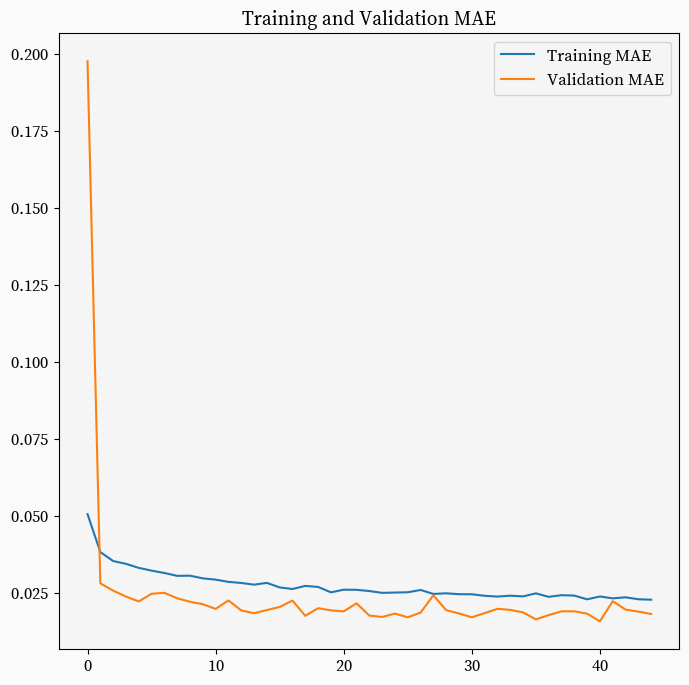

In [5]:
#| code-fold: true
#| warning: false
#| error: false

acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training MAE')
plt.plot(epochs_range, val_acc, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

188/188 [==============================] - 1s 2ms/step
Overlap ratio: 1.0
(Min, Max, Avg) STD: 0.0027240268 0.039169762 0.013859627
Pearson's correlation coeff:  0.9859954254209227


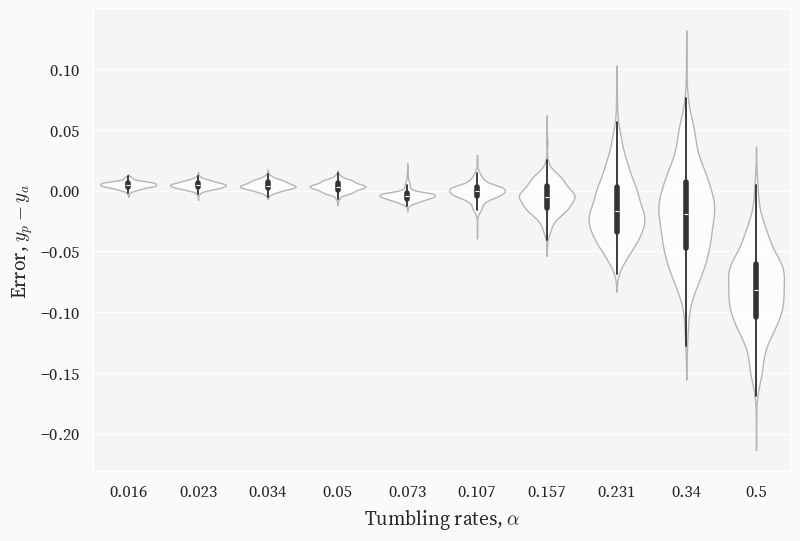

In [6]:
#| code-fold: true
#| warning: false
#| error: false

predict_and_plot(model, x_val, y_val)

In [7]:
#| code-fold: true
#| warning: false
#| error: false
# Save the model here

name = "virus9177"
model.save(f"models/{name}.keras")
np.save(f"models/{name}.npy",history.history)

In [8]:
#| code-fold: true
#| warning: false
#| error: false

import gc

del model
del history

print("Collected: ", gc.collect())

Collected:  7294


# No-orientation 6 (comma1065)

In [11]:
#| code-fold: true
#| warning: false
#| error: false

tf.keras.utils.set_random_seed(1065)

model = make_net(shape)
# Slightly slower adam and SGD
adam = keras.optimizers.Adam(learning_rate=0.0002)
sgd = keras.optimizers.SGD(learning_rate=0.008)
model.compile(loss='mae', optimizer=sgd, metrics=['mae'])

In [12]:
#| code-fold: true
#| warning: false
#| error: false

epochs=45
batch_size=64
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose=2,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)
print("Evaluate on test data:")
results = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=0)
print("Test loss:", results)

2024-03-14 20:47:03.756266: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.
2024-03-14 20:47:04.343170: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.


Epoch 1/45
375/375 - 4s - loss: 0.0857 - mae: 0.0857 - val_loss: 0.1680 - val_mae: 0.1680 - 4s/epoch - 11ms/step
Epoch 2/45
375/375 - 3s - loss: 0.0636 - mae: 0.0636 - val_loss: 0.0498 - val_mae: 0.0498 - 3s/epoch - 8ms/step
Epoch 3/45
375/375 - 3s - loss: 0.0538 - mae: 0.0538 - val_loss: 0.0399 - val_mae: 0.0399 - 3s/epoch - 8ms/step
Epoch 4/45
375/375 - 3s - loss: 0.0479 - mae: 0.0479 - val_loss: 0.0413 - val_mae: 0.0413 - 3s/epoch - 8ms/step
Epoch 5/45
375/375 - 3s - loss: 0.0444 - mae: 0.0444 - val_loss: 0.0380 - val_mae: 0.0380 - 3s/epoch - 8ms/step
Epoch 6/45
375/375 - 3s - loss: 0.0418 - mae: 0.0418 - val_loss: 0.0337 - val_mae: 0.0337 - 3s/epoch - 8ms/step
Epoch 7/45
375/375 - 3s - loss: 0.0398 - mae: 0.0398 - val_loss: 0.0318 - val_mae: 0.0318 - 3s/epoch - 8ms/step
Epoch 8/45
375/375 - 3s - loss: 0.0386 - mae: 0.0386 - val_loss: 0.0348 - val_mae: 0.0348 - 3s/epoch - 8ms/step
Epoch 9/45
375/375 - 3s - loss: 0.0373 - mae: 0.0373 - val_loss: 0.0245 - val_mae: 0.0245 - 3s/epoch - 

Text(0.5, 1.0, 'Training and Validation MAE')

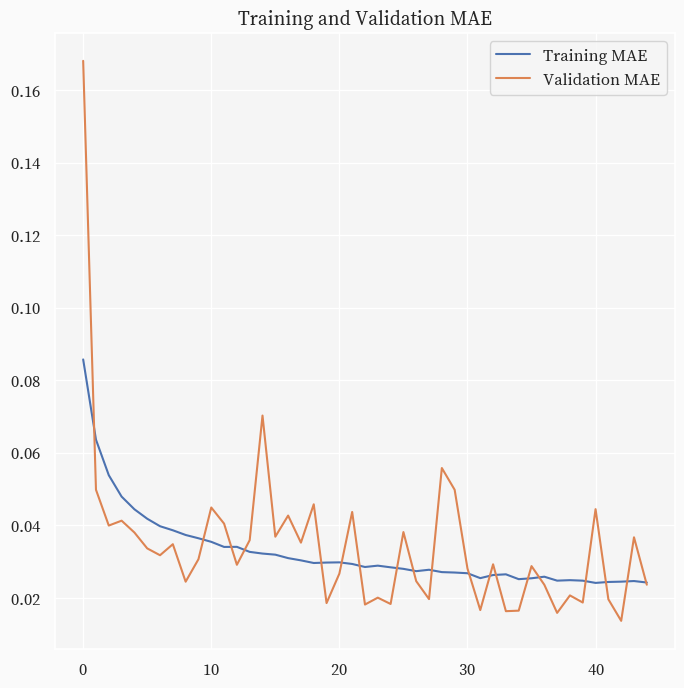

In [13]:
#| code-fold: true
#| warning: false
#| error: false

acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training MAE')
plt.plot(epochs_range, val_acc, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

188/188 [==============================] - 0s 2ms/step
Overlap ratio: 0.8
(Min, Max, Avg) STD: 0.002132868 0.051503256 0.015806586
Pearson's correlation coeff:  0.9825176314893705


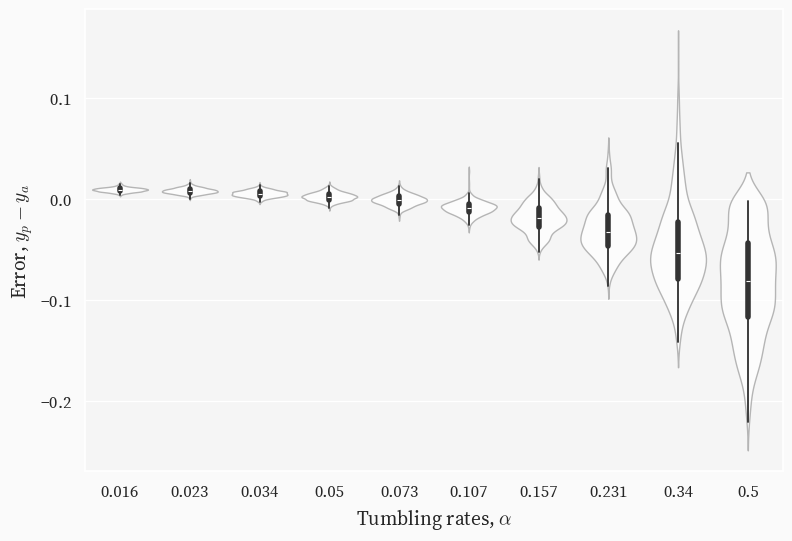

In [14]:
#| code-fold: true
#| warning: false
#| error: false

predict_and_plot(model, x_val, y_val)

In [15]:
#| code-fold: true
#| warning: false
#| error: false
# Save the model here

name = "comma1065"
model.save(f"models/{name}.keras")
np.save(f"models/{name}.npy",history.history)

In [20]:
#| code-fold: true
#| warning: false
#| error: false

import gc

del model
del history

print("Collected: ", gc.collect())

Collected:  15410


# No-orientation 7 (toys6730)

In [4]:
#| code-fold: true
#| warning: false
#| error: false

tf.keras.utils.set_random_seed(6730)

model = make_net(shape)
# Slightly slower adam and SGD
adam = keras.optimizers.Adam(learning_rate=0.0002)
sgd = keras.optimizers.SGD(learning_rate=0.008)
model.compile(loss='mae', optimizer=sgd, metrics=['mae'])

2024-03-14 20:09:55.502891: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4305 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:07:00.0, compute capability: 7.5


In [5]:
#| code-fold: true
#| warning: false
#| error: false

epochs=45
batch_size=64
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose=2,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)
print("Evaluate on test data:")
results = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=0)
print("Test loss:", results)

2024-03-14 20:09:58.510948: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.
2024-03-14 20:10:00.905648: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1572864000 exceeds 10% of free system memory.


Epoch 1/45


2024-03-14 20:10:01.828515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2024-03-14 20:10:02.223551: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x771ac870a9b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-14 20:10:02.223579: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-03-14 20:10:02.424066: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 - 6s - loss: 0.0589 - mae: 0.0589 - val_loss: 0.0797 - val_mae: 0.0797 - 6s/epoch - 15ms/step
Epoch 2/45
375/375 - 3s - loss: 0.0388 - mae: 0.0388 - val_loss: 0.0332 - val_mae: 0.0332 - 3s/epoch - 8ms/step
Epoch 3/45
375/375 - 3s - loss: 0.0352 - mae: 0.0352 - val_loss: 0.0280 - val_mae: 0.0280 - 3s/epoch - 8ms/step
Epoch 4/45
375/375 - 3s - loss: 0.0335 - mae: 0.0335 - val_loss: 0.0261 - val_mae: 0.0261 - 3s/epoch - 8ms/step
Epoch 5/45
375/375 - 3s - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0245 - val_mae: 0.0245 - 3s/epoch - 8ms/step
Epoch 6/45
375/375 - 3s - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0246 - val_mae: 0.0246 - 3s/epoch - 8ms/step
Epoch 7/45
375/375 - 3s - loss: 0.0310 - mae: 0.0310 - val_loss: 0.0232 - val_mae: 0.0232 - 3s/epoch - 8ms/step
Epoch 8/45
375/375 - 3s - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0223 - val_mae: 0.0223 - 3s/epoch - 8ms/step
Epoch 9/45
375/375 - 3s - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0246 - val_mae: 0.0246 - 3s/epoch - 8ms/step
Ep

Text(0.5, 1.0, 'Training and Validation MAE')

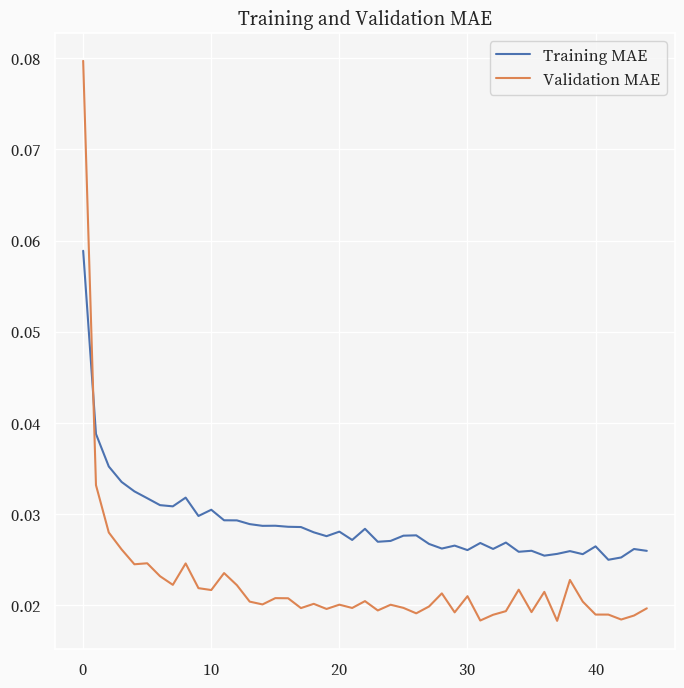

In [8]:
#| code-fold: true
#| warning: false
#| error: false

acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training MAE')
plt.plot(epochs_range, val_acc, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

188/188 [==============================] - 1s 3ms/step
Overlap ratio: 1.0
(Min, Max, Avg) STD: 7.271417e-05 0.039254803 0.015651431
Pearson's correlation coeff:  0.9811996701848624


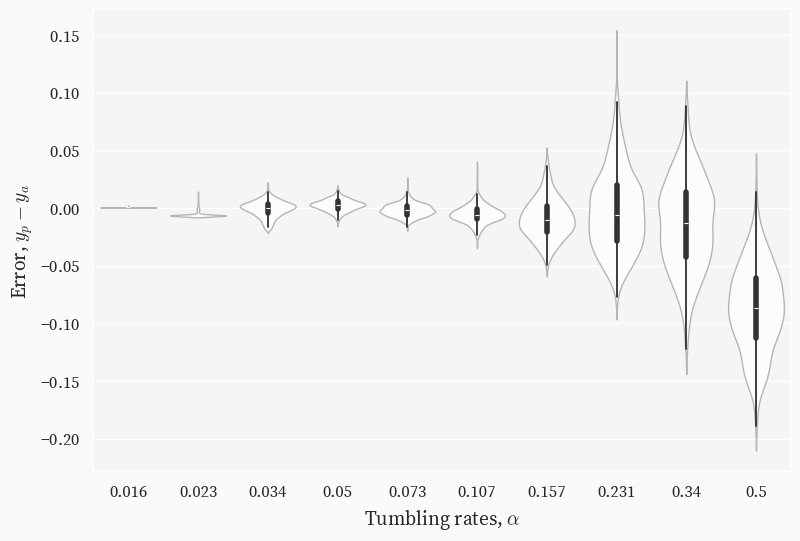

In [7]:
#| code-fold: true
#| warning: false
#| error: false

predict_and_plot(model, x_val, y_val)

In [9]:
#| code-fold: true
#| warning: false
#| error: false
# Save the model here

name = "toys6730"
model.save(f"models/{name}.keras")
np.save(f"models/{name}.npy",history.history)

In [10]:
#| code-fold: true
#| warning: false
#| error: false

import gc

del model
del history

print("Collected: ", gc.collect())

Collected:  8613


# Summary

In [100]:
#| code-fold: true
#| warning: false
#| error: false
#| output: false

model_names = [
    "ice1822",
    "house9539",
    "cake2409",
    "carrot8290",
    "virus9177",
    "comma1065",
    "toys6730"
]
predictions, actual = predict_multi_by_name(model_names, x_val, y_val)

Overlap ratio: 1.0
(Min, Max, Avg) STD: 0.004649618 0.058048625 0.022141198
Pearson's correlation coeff:  0.9735606205360013


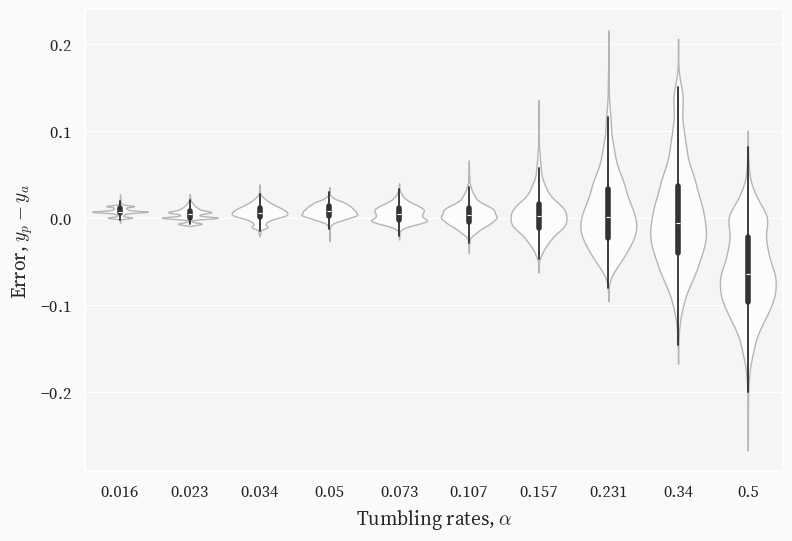

In [102]:
#| code-fold: true
#| warning: false
#| error: false

plot_violin_and_statistics(predictions,actual)

In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
df = pd.DataFrame()
df.insert(0, "predicted", predictions - actual)
df.insert(1, "actual", actual)

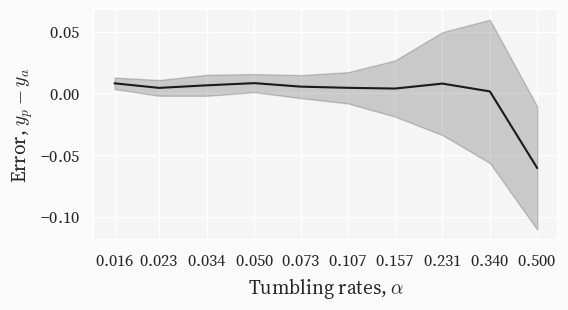

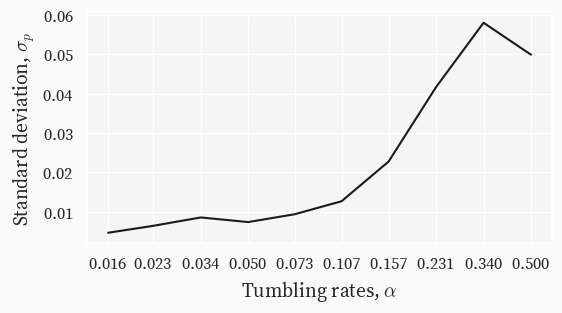

In [104]:
fig, ax = plt.subplots(figsize=(6,3))
sns.lineplot(ax=ax, data=df, x="actual", y="predicted", errorbar=("sd", 1), c='k')
ax.set(xlabel=r"Tumbling rates, $\alpha$", ylabel=r"Error, $y_p - y_a$")
ax.set_xscale('log')
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xticks(np.unique(actual))
fig, ax = plt.subplots(figsize=(6,3))
sns.lineplot(c='k', ax=ax, x=np.unique(actual), y=df.groupby('actual', as_index=False)['predicted'].std()['predicted'])
ax.set(xlabel=r"Tumbling rates, $\alpha$", ylabel=r"Standard deviation, $\sigma_p$")
ax.set_xscale('log')
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xticks(np.unique(actual))